# 1.0) **Preliminar analysis: pixel priors and labels mapping**

### visualization and effects of interpolation

In [ ]:
#print example from datasets to check if are correct (do color remapping)
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def plot_image(ax, image_path, title=None, anomaly_det_label=False, transform=None):
    # Load the image using PIL
    if transform is None:
      image = np.asarray(Image.open(image_path)).copy()
    else:
      image_file = Image.open(image_path)
      image_torch = transform(image_file)
      image_swap_dim = image_torch.permute(1,2,0)
      image = np.array(image_swap_dim)

    if anomaly_det_label: #NOTE: RoadAnomaly has only 2 labels -> mapped automatically by imshow to have significantly different colors
      image[np.where(image==1)]=127


    # Plot the image on the axis
    ax.imshow(image)
    ax.set_title(title)

    return image.shape[0],image.shape[1]


def confront_img(id, datasets, formats, root_dir_ds, transform=(None,None)):

    tot_ds = len(datasets)
    # Create a figure and axis
    fig, ax = plt.subplots(tot_ds, 2, figsize=(15, 8))
    plt.subplots_adjust(top=2.5,bottom=0.0)  # Adjust this value as needed, is in inches

    image_prop = []

    for i,(ds,fmt) in enumerate(zip(datasets,formats)):

        plot_image(ax[i][0], f'{root_dir_ds}/{ds}/images/{id}{fmt}', title='Image', transform=transform[0])
        W,H = plot_image(ax[i][1], f'{root_dir_ds}/{ds}/labels_masks/{id}.png', title='Label', anomaly_det_label=True, transform=transform[1])
        image_prop.append(H/W)



    for i,ds in enumerate(datasets):
        if i==0:
            pos = 0.0
        else:
            pos += image_prop[i-1]/sum(image_prop)

        fig.text(0.5, 2.5*(1-0.2*i), ds, ha='center', fontsize=20)


    plt.show()



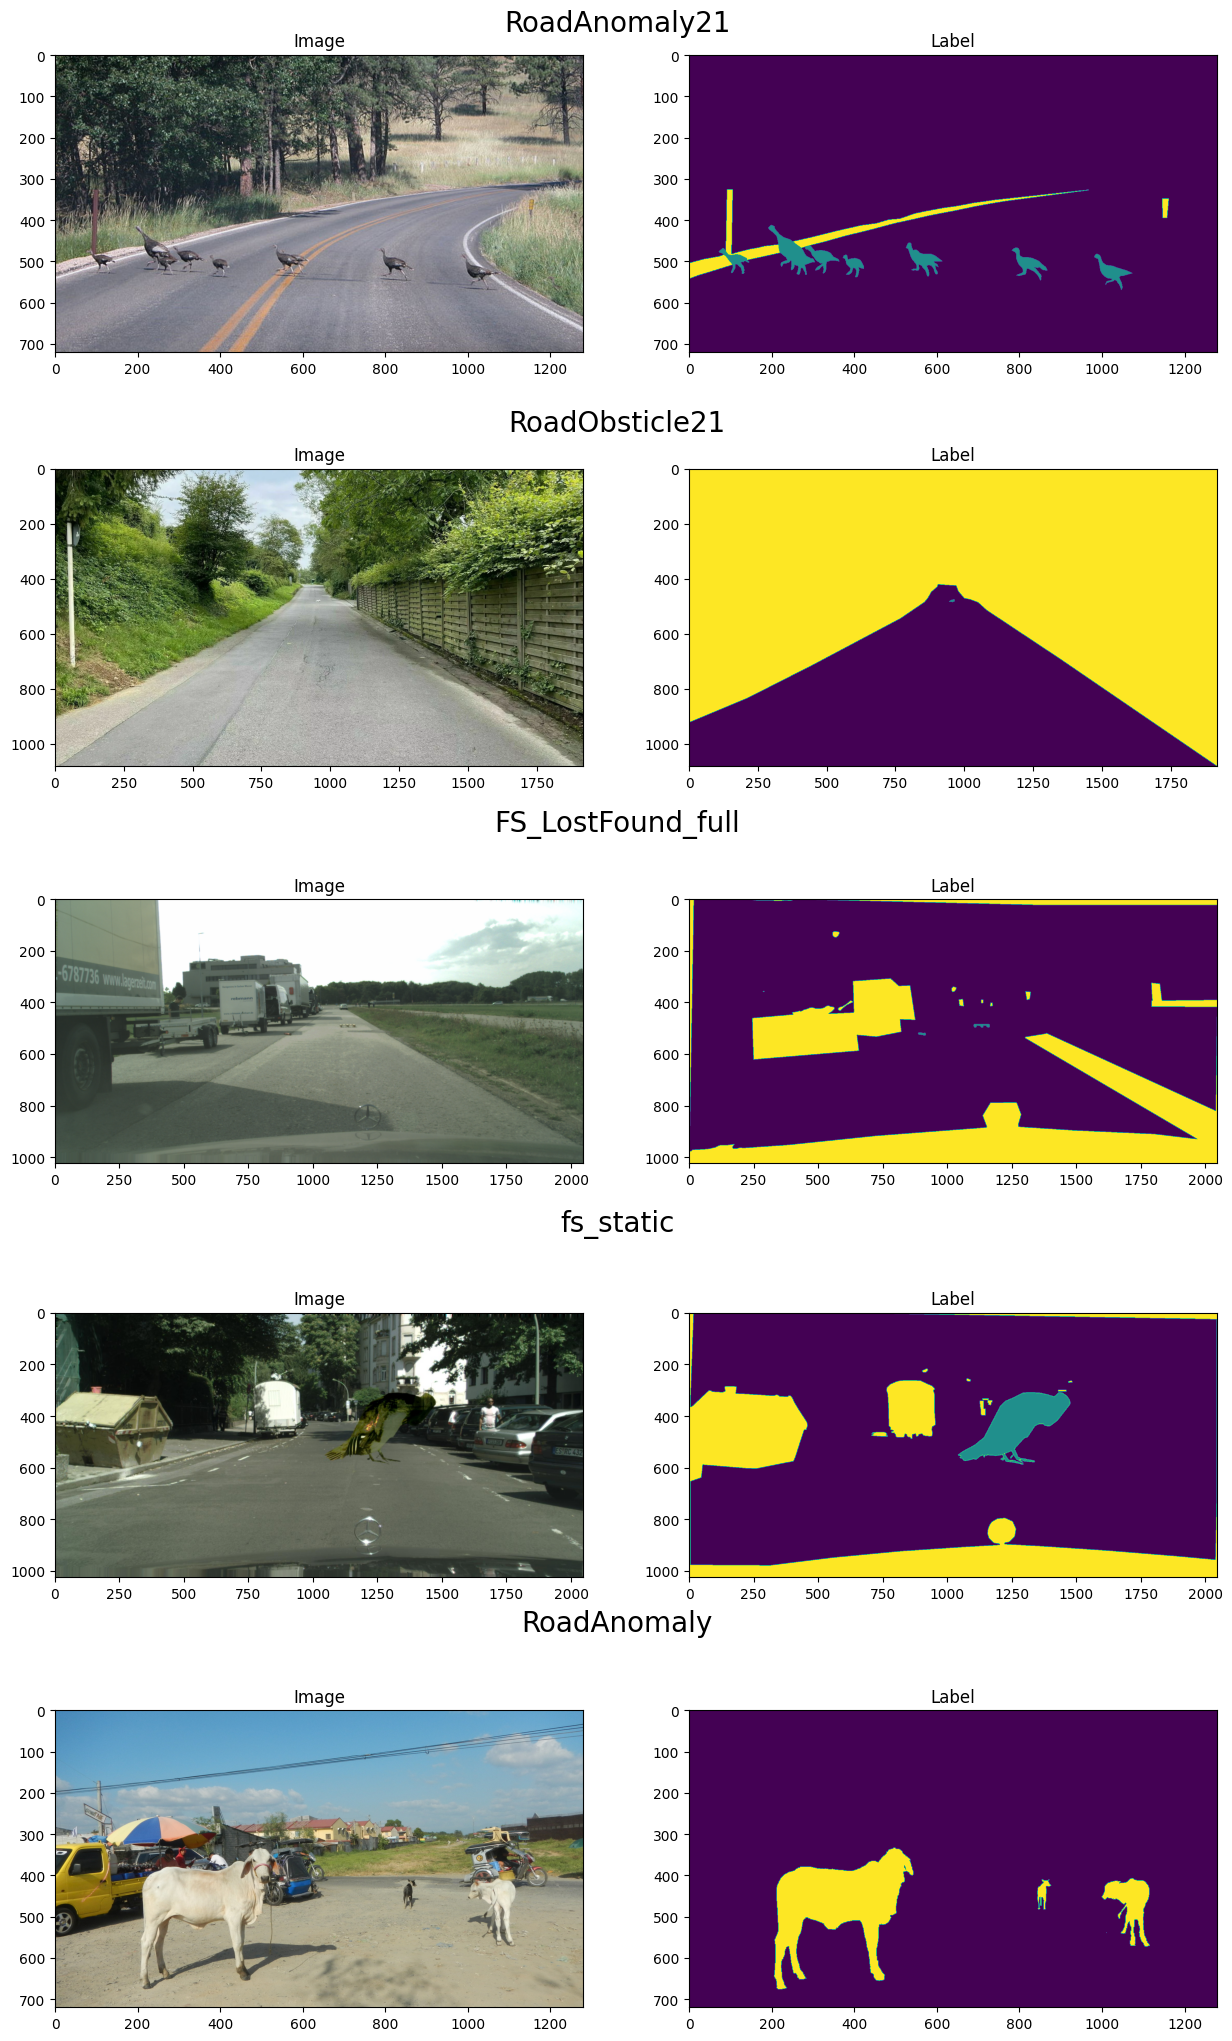

In [ ]:
import os
folder_path = ROOT_DIR + "/eval"
os.chdir(folder_path)

#ORIGINAL IMAGE
confront_img(
    0,
    ['RoadAnomaly21', 'RoadObsticle21', 'FS_LostFound_full', 'fs_static', 'RoadAnomaly'],
    ['.png', '.webp', '.png', '.jpg', '.jpg'],
    ROOT_DIR+"/datasets/Validation_Dataset"
)

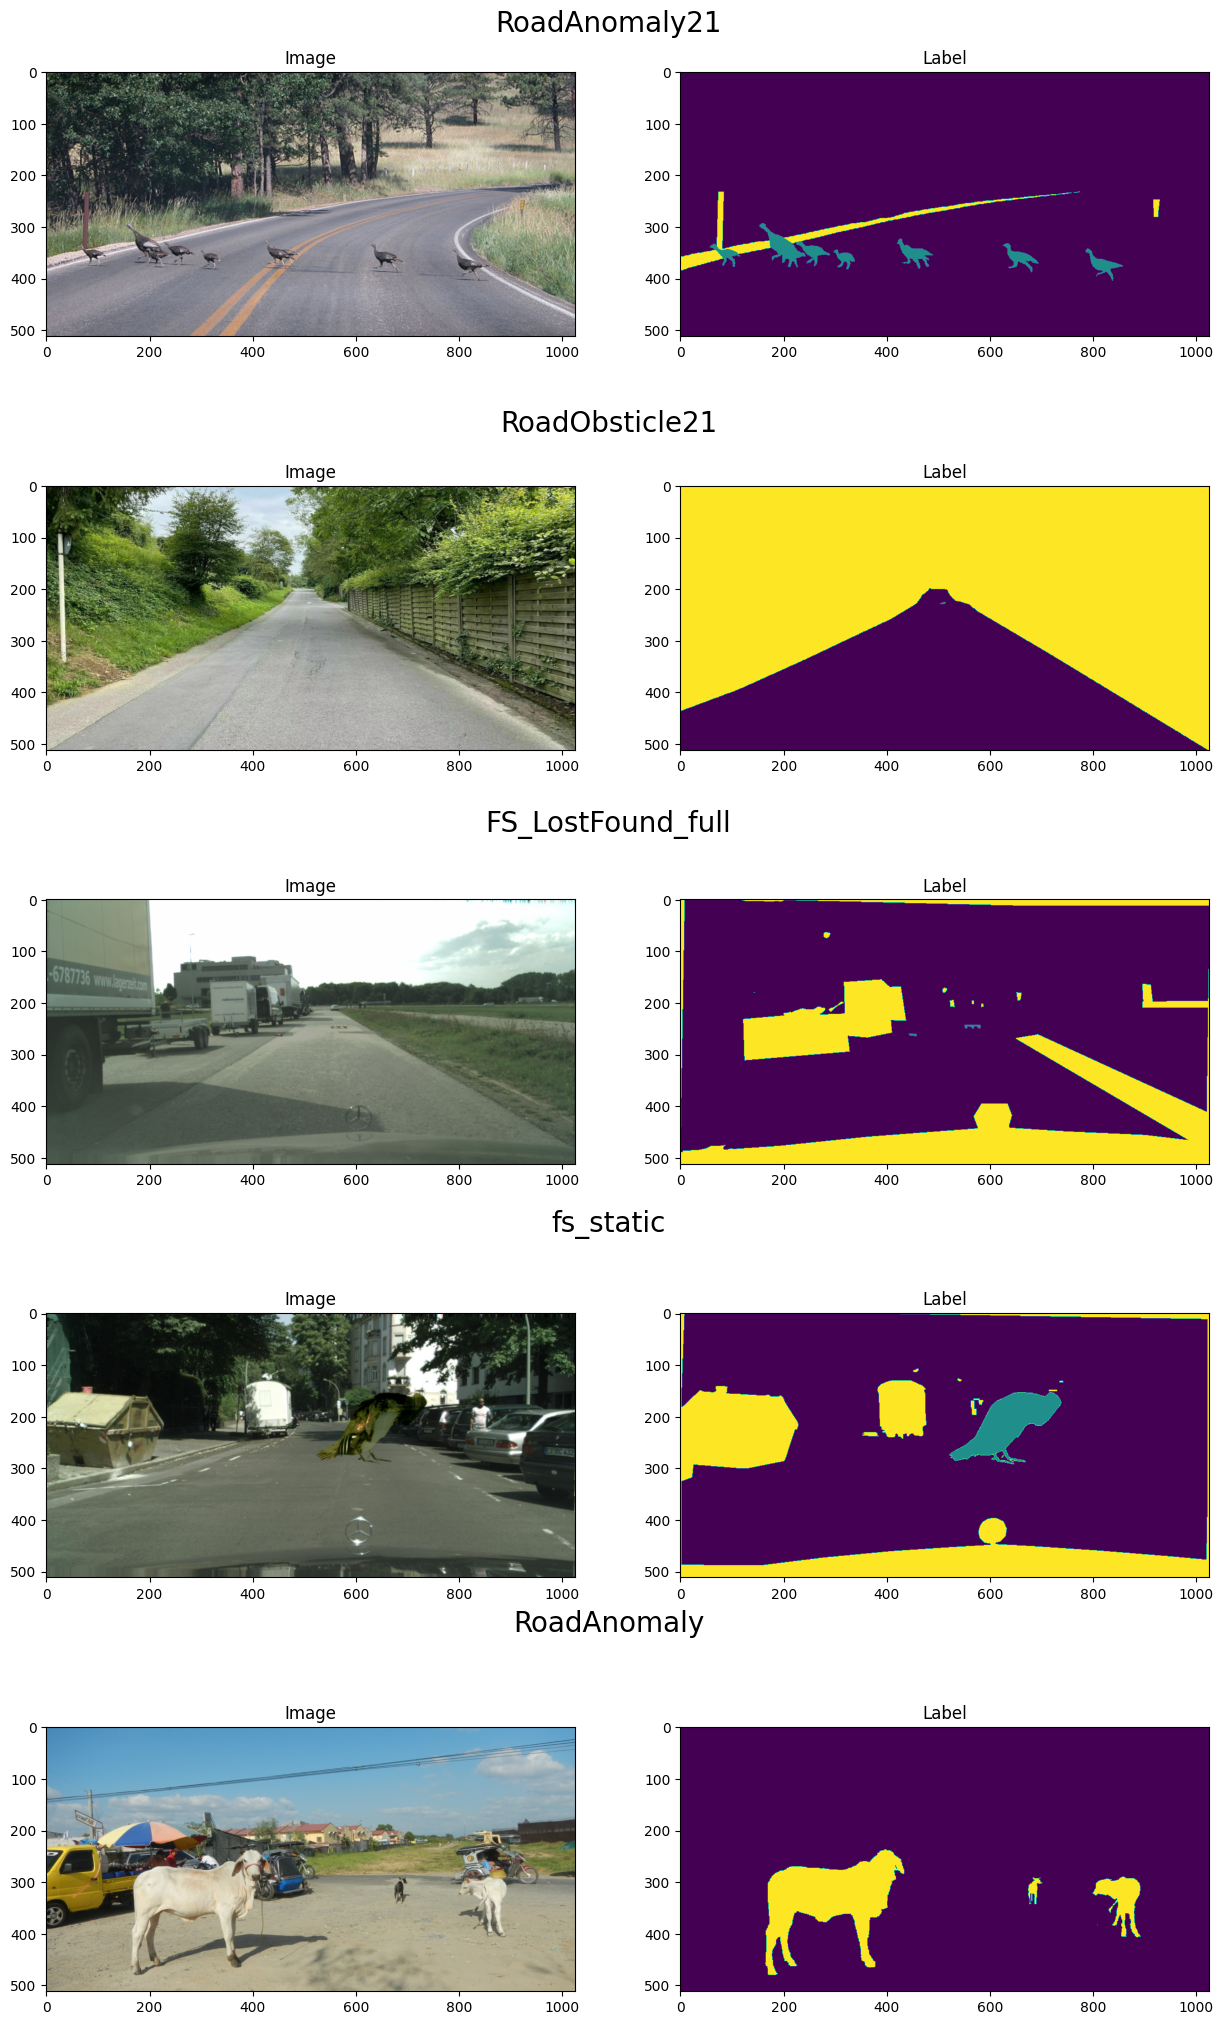

In [ ]:
import os
folder_path = ROOT_DIR + "/eval"
os.chdir(folder_path)

#RESHAPED IMAGES
from torchvision.transforms import Compose, CenterCrop, Normalize, Resize
from transform import ToLabel
from torchvision.transforms import ToTensor

from PIL import Image

input_transform = Compose([
  Resize((512, 1024), Image.BILINEAR),
  ToTensor()
]) #changed according to eval_iou

label_transform = Compose([
 Resize((512, 1024), Image.NEAREST), #Interpolation.NEAREST id ONLY type of interpolation that preserves labels mapping
 ToLabel()
])

confront_img(
    0,
    ['RoadAnomaly21', 'RoadObsticle21', 'FS_LostFound_full', 'fs_static', 'RoadAnomaly'],
    ['.png', '.webp', '.png', '.jpg', '.jpg'],
    ROOT_DIR+"/datasets/Validation_Dataset",
    transform = (input_transform, label_transform)
)

### Class/anomaly priors

In [ ]:
import os
from collections import defaultdict
from PIL import Image
import numpy as np

import os
folder_path = ROOT_DIR + "/eval"
os.chdir(folder_path)


cityscape_map = [
  'Road',
  'Sidewalk',
  'Building',
  'Wall',
  'Fence',
  'Pole',
  'Traffic Light',
  'Traffic Sign',
  'Vegetation',
  'Terrain',
  'Sky',
  'Person',
  'Rider',
  'Car',
  'Truck',
  'Bus',
  'Train',
  'Motorcycle',
  'Bicycle',
  'Unknown'
]

#check to have 30000 file (11.6GB) in total in train forlder

def count_unique_pixels(folder_path, suffix=".png"):
    # Dictionary to store pixel value counts
    pixel_counts = defaultdict(int)

    # Iterate through all files in the folder
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if os.path.isfile(file_path) and file_path.endswith((suffix)): #only needed labels
            # Open the image
            with Image.open(file_path) as img:
                # Convert image to grayscale (BW)
                bw_img = img.convert('L')

                # Convert image to numpy array
                pixel_array = np.array(bw_img)

                # Flatten the array and count unique pixel values
                unique, counts = np.unique(pixel_array, return_counts=True)
                for pixel_value, count in zip(unique, counts):
                    pixel_counts[pixel_value] += count

    return pixel_counts

print("CITYSCAPE")

val_path = ROOT_DIR + "/datasets/Train_Dataset/gtFine/val" #usually smallest subdataset

from os import listdir
from os.path import join



unique_pixel_counts = {}
# Get the unique pixel counts
for filename in os.listdir(val_path):
    subfolder_path = os.path.join(val_path, filename) #join cities paths
    if len(unique_pixel_counts.keys())==0:
        unique_pixel_counts = count_unique_pixels(subfolder_path, suffix='TrainIds.png')
    else:#assume that all categories are seen in 1st city
        for key in unique_pixel_counts.keys():
            to_upd=count_unique_pixels(subfolder_path, suffix='TrainIds.png')
            unique_pixel_counts[key]+=to_upd[key]

# Print the results
print(" Pixel distr validation test:")
for n_label,(pixel_value, count) in enumerate(sorted(unique_pixel_counts.items())):
    print(f' Class: {cityscape_map[n_label]}, Pixel value: {pixel_value}, P(class\|pixel): {count/sum(list(unique_pixel_counts.values()))} occurrences')

print("\n\n\n")


test_map = {

    'RoadAnomaly21':[
        "known (cs [0,18])",
        "anomaly", #big
        "unknown (cs 19)" #skipped in evalAnomaly.py
    ],

    'RoadObsticle21':[
        "road region",
        "anomaly", #small, on-road (->obstacle)
        "not road region" #skipped in evalAnomaly.py
    ],

    'FS_LostFound_full':[
        "known (cs [0,18])", #0
        "anomaly", #small #1
        "unknown (cs 19)" #skipped in evalAnomaly.py
    ],

    'fs_static':[
        "known (cs [0,18])",
        "anomaly", #medium, artificially pasted (NOTE: luggage on road are not considered object in image 4, bias?)
        "unknown (cs 19)" #skipped in evalAnomaly.py
    ],

    'RoadAnomaly':[
        "known (cs [0,19])",
        "anomaly" #big
    ]
}


for ds in ['RoadAnomaly21', 'RoadObsticle21', 'FS_LostFound_full', 'fs_static', 'RoadAnomaly']:

    print(ds)

    val_path = ROOT_DIR + f"/datasets/Validation_Dataset/{ds}/labels_masks" #usually smallest subdataset

    unique_pixel_counts = count_unique_pixels(val_path) #no subfolders

    print(" Pixel distr validation test:")
    for n_label,(pixel_value, count) in enumerate(sorted(unique_pixel_counts.items())):
        print(f' Class: {test_map[ds][n_label]}, Pixel value: {pixel_value}, P(class\|pixel): {count/sum(list(unique_pixel_counts.values()))} occurrences')

    print("\n\n\n")


CITYSCAPE
 Pixel distr validation test:
 Class: Road, Pixel value: 0, P(class\|pixel): 0.3292293643951416 occurrences
 Class: Sidewalk, Pixel value: 1, P(class\|pixel): 0.04726318836212158 occurrences
 Class: Building, Pixel value: 2, P(class\|pixel): 0.19158866214752196 occurrences
 Class: Wall, Pixel value: 3, P(class\|pixel): 0.006409337997436523 occurrences
 Class: Fence, Pixel value: 4, P(class\|pixel): 0.00717833137512207 occurrences
 Class: Pole, Pixel value: 5, P(class\|pixel): 0.012936335563659668 occurrences
 Class: Traffic Light, Pixel value: 6, P(class\|pixel): 0.0017297258377075196 occurrences
 Class: Traffic Sign, Pixel value: 7, P(class\|pixel): 0.005827383041381836 occurrences
 Class: Vegetation, Pixel value: 8, P(class\|pixel): 0.15133179950714112 occurrences
 Class: Terrain, Pixel value: 9, P(class\|pixel): 0.007272659301757812 occurrences
 Class: Sky, Pixel value: 10, P(class\|pixel): 0.02928550148010254 occurrences
 Class: Person, Pixel value: 11, P(class\|pixel): 0


### Image resolutions:
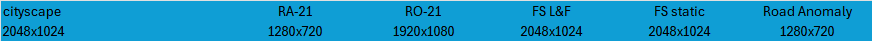

### Benchmark datasets:



- Cnoice of dataset as in:
```
@misc{rai2023unmasking,
      title={Unmasking Anomalies in Road-Scene Segmentation},
      author={Shyam Nandan Rai and Fabio Cermelli and Dario Fontanel and Carlo Masone and Barbara Caputo},
      year={2023},
      eprint={2307.13316},
      archivePrefix={arXiv},
      primaryClass={cs.CV}
}


- Cityscape:
```
@misc{cordts2016cityscapes,
      title={The Cityscapes Dataset for Semantic Urban Scene Understanding},
      author={Marius Cordts and Mohamed Omran and Sebastian Ramos and Timo Rehfeld and Markus Enzweiler and Rodrigo Benenson and Uwe Franke and Stefan Roth and Bernt Schiele},
      year={2016},
      eprint={1604.01685},
      archivePrefix={arXiv},
      primaryClass={cs.CV}
}


-  Fishyscapes: https://fishyscapes.com
##### FS L&F, FS static
```
@article{Blum_2021,
   title={The Fishyscapes Benchmark: Measuring Blind Spots in Semantic Segmentation},
   volume={129},
   ISSN={1573-1405},
   url={http://dx.doi.org/10.1007/s11263-021-01511-6},
   DOI={10.1007/s11263-021-01511-6},
   number={11},
   journal={International Journal of Computer Vision},
   publisher={Springer Science and Business Media LLC},
   author={Blum, Hermann and Sarlin, Paul-Edouard and Nieto, Juan and Siegwart, Roland and Cadena, Cesar},
   year={2021},
   month=sep, pages={3119–3135} }


- SMYC: https://segmentmeifyoucan.com
  RoadObstacle21, RoadAnomaly21
```
@misc{chan2021segmentmeifyoucan,
      title={SegmentMeIfYouCan: A Benchmark for Anomaly Segmentation},
      author={Robin Chan and Krzysztof Lis and Svenja Uhlemeyer and Hermann Blum and Sina Honari and Roland Siegwart and Pascal Fua and Mathieu Salzmann and Matthias Rottmann},
      year={2021},
      eprint={2104.14812},
      archivePrefix={arXiv},
      primaryClass={cs.CV}
}

- RoadAnomaly: https://www.epfl.ch/labs/cvlab/data/road-anomaly/
```
@misc{lis2019detecting,
      title={Detecting the Unexpected via Image Resynthesis},
      author={Krzysztof Lis and Krishna Nakka and Pascal Fua and Mathieu Salzmann},
      year={2019},
      eprint={1904.07595},
      archivePrefix={arXiv},
      primaryClass={cs.CV}
}



